In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import quandl
from stockAnalysisTools import numToString

#### The cell below will be used to pull all the stock data we want and make a dictionary for accessing it

In [2]:
quandl.ApiConfig.api_key = "d1JcayaRuvKSaq7GaEHs"
aapl = "aapl"
goog  = "goog"
stockList = [aapl, goog]
finData = dict()

for ticker in stockList:
    finData[ticker] = quandl.get("WIKI/"+ticker)["Adj. Close"]

In [15]:
class Stock(object):
    
    def __init__(self, name):
        self.name = name
        self.percentage = 0.0
        
    def set_portfolio_percentage(self, val):
        if val > 100.0 or val < 0.0:
            print("Invalid value. A stock can only occupy between 0 - 100 percent of a portfolio")
        else:
            self.percentage = val/100.0
        
            

In [16]:
class Portfolio(object):
    stocks = list()
    uninvestedMoney = 0
    
    def addStock(self, stock):
        
        if(stock.name not in finData.keys()):
            print("We haven't pulled up data for this stock, so it can't be added")
            return
        
        self.stocks.append(stock)
    
    def addMoney(self, money):
        
        self.uninvestedMoney += money
        
    def reset(self):
        self.uninvestedMoney = 0
        if len(self.stocks) != 0:
            self.stocks = []      

#### Creating Portfolio

In [17]:
my_portfolio = Portfolio()
aapl = Stock("aapl")
aapl.set_portfolio_percentage(50)
goog = Stock("goog")
goog.set_portfolio_percentage(50)
my_portfolio.addStock(aapl)
my_portfolio.addStock(goog)

#### Simple Trading Strategy per 30 days

In [20]:
startDate = '2001-07-01'
endDate = '2018-07-01'

aaplReturn = finData[aapl.name].loc[startDate: endDate].pct_change().shift(-1).dropna()
aaplSharpe = aaplReturn.mean()/aaplReturn.std()
aaplRollingStat = finData[aapl.name].loc[startDate: endDate].rolling(window=30,center=False).mean().dropna()
aaplRollingStd = finData[aapl.name].loc[startDate: endDate].rolling(window=30,center=False).std().dropna()

aaplRollingStat = aaplRollingStat.reset_index()

aaplRollingStat = aaplRollingStat.rename(index=str, columns={"Adj. Close": "Rolling Mean"})
aaplRollingStat["Std"] = aaplRollingStd.values
aaplRollingStat["Upper Band"] = aaplRollingStat.apply(lambda row: row["Rolling Mean"] + 2*row["Std"], axis=1)
aaplRollingStat["Lower Band"] = aaplRollingStat.apply(lambda row: row["Rolling Mean"] - 2*row["Std"], axis=1)

aaplRollingStat = aaplRollingStat.set_index("Date")

aaplRollingStat["Adj. Close"] = finData[aapl.name].loc[aaplRollingStat.index[0]:aaplRollingStat.index[-1]].values

In [21]:
startDate = '2001-07-01'
endDate = '2018-07-01'

googReturn = finData[goog.name].loc[startDate: endDate].pct_change().shift(-1).dropna()
googSharpe = googReturn.mean()/googReturn.std()
googRollingStat = finData[goog.name].loc[startDate: endDate].rolling(window=30,center=False).mean().dropna()
googRollingStd = finData[goog.name].loc[startDate: endDate].rolling(window=30,center=False).std().dropna()

googRollingStat = googRollingStat.reset_index()

googRollingStat = googRollingStat.rename(index=str, columns={"Adj. Close": "Rolling Mean"})
googRollingStat["Std"] = googRollingStd.values
googRollingStat["Upper Band"] = googRollingStat.apply(lambda row: row["Rolling Mean"] + 2*row["Std"], axis=1)
googRollingStat["Lower Band"] = googRollingStat.apply(lambda row: row["Rolling Mean"] - 2*row["Std"], axis=1)

googRollingStat = googRollingStat.set_index("Date")

googRollingStat["Adj. Close"] = finData[goog.name].loc[googRollingStat.index[0]:googRollingStat.index[-1]].values

## Stratagey In Practice

In [22]:
#portfolio reset
my_portfolio.reset()
my_portfolio.addMoney(100)

In [25]:
aaplRollingStat = aaplRollingStat.reset_index()

aaplRollingStat["Buy Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
aaplRollingStat["Sell Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

aaplRollingStat = aaplRollingStat.set_index("Date")


return_aapl = pd.DataFrame()
return_aapl["Position"] =aaplRollingStat["Buy Day"]
return_aapl["Adj. Close"] = aaplRollingStat["Adj. Close"]

return_aapl["Returns"] = aaplReturn *  return_aapl["Position"]
return_aapl["Returns"] = return_aapl["Returns"].dropna()

In [27]:
googRollingStat = googRollingStat.reset_index()

googRollingStat["Buy Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
googRollingStat["Sell Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

googRollingStat = googRollingStat.set_index("Date")


return_goog = pd.DataFrame()
return_goog["Position"] =googRollingStat["Buy Day"]
return_goog["Adj. Close"] = googRollingStat["Adj. Close"]

return_goog["Returns"] = googReturn *  return_goog["Position"]
return_goog["Returns"] = return_goog["Returns"].dropna()

return_goog = return_goog.reindex(return_aapl.index).replace(np.nan, 0)
return_goog["Returns"][-1] = np.nan
# return_goog #= return_goog.replace(np.nan, 0)

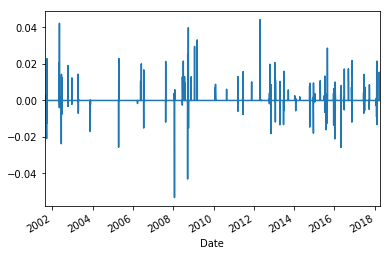

Date
2001-08-13    1.000000
2001-08-14    1.000000
2001-08-15    1.000000
2001-08-16    1.000000
2001-08-17    1.000000
2001-08-20    1.000000
2001-08-21    1.000000
2001-08-22    1.000000
2001-08-23    1.000000
2001-08-24    1.000000
2001-08-27    1.000000
2001-08-28    1.000000
2001-08-29    1.000000
2001-08-30    1.000000
2001-08-31    1.000000
2001-09-04    1.000000
2001-09-05    1.000000
2001-09-06    1.000000
2001-09-07    1.005208
2001-09-10    1.005208
2001-09-17    0.963201
2001-09-18    1.006983
2001-09-19    1.006983
2001-09-20    1.010194
2001-09-21    1.056433
2001-09-24    1.056433
2001-09-25    1.029921
2001-09-26    1.054394
2001-09-27    1.054394
2001-09-28    1.054394
                ...   
2018-02-13    2.122683
2018-02-14    2.122683
2018-02-15    2.122683
2018-02-16    2.122683
2018-02-20    2.122683
2018-02-21    2.122683
2018-02-22    2.122683
2018-02-23    2.122683
2018-02-26    2.122683
2018-02-27    2.122683
2018-02-28    2.122683
2018-03-01    2.122683
2018-0

In [32]:
returns = (return_aapl["Returns"]*aapl.percentage) + (return_goog["Returns"]*goog.percentage)
ret_plt =  returns.plot()
plt.show()

list_of_returns = list()
list_of_returns.append(((1+return_aapl["Returns"]).dropna()).cumprod()[-1])
list_of_returns.append(((1+return_goog["Returns"]).dropna()).cumprod()[-1])
(1+return_aapl["Returns"]).cumprod()
# ((1+return_aapl["Returns"]).dropna()).cumprod()
# print("Percent return of the portfolio: ", sum(list_of_returns)/len(list_of_returns))